## Model Diagnostics

We have now constructed our model.  Lets take a closer look at the results.

In [1]:
# Reading in neccessary packages
import pandas as pd
import numpy as np
from project_functions.analysis_functions import plot, mse, transform, saveModel, loadModel, modelTraining, createUsableDF, score, boostModel
import matplotlib.pyplot as plt
# This package only neccessary if you would like to re-download the data int the nexyt
# import yahoo_finance as yf

In [2]:
data = pd.read_csv('Data/Raw Data/forward.csv', index_col='Date')

xTrain, yTrain, xTest, yTest, scaler = transform(data)

MSE Train: 0.026805853110043028
MSE Test: 0.004708414955350479


C:\Users\Aidan\Documents\GitRepositories\cmpt-353-stock-market-predictor\project_functions\analysis_functions.py:208: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


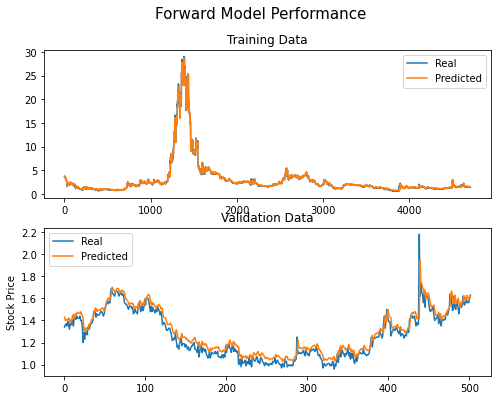

In [3]:
model = loadModel(name='forwardComplete',location='Data/Final Models')

mseTrain, trainPreds, trainTruth = mse(xTrain,yTrain, model, scaler)
print("MSE Train:", mseTrain)

mseTest, testPreds, testTruth = mse(xTest,yTest, model, scaler)

print("MSE Test:", mseTest)

plot(trainTruth, trainPreds, testTruth, testPreds, 'Forward Model Performance')

## Model Diagnostics and Performance

Looking at the plot of our model, we can see it does very well on the training data, but systematically overestimates the the testing data.  Before deciding if this is in fact a problem, lets see the results of this in a simulation of stock trades we would like to make.  How these trades are defined is simple, let change = PredictedOpeningPrice - CurrentOpeningPrice.  That is change represents the predicted change in the opening stock price between the current day and the next day.  If change is positive (> 0), we will buy stock at the current opening price since we believe we wil be able to sell it tomorrow for a profit.  If change is negative (<=0), we will sell stock (if we have any to sell) at the current opening price since we think the price is going to go down.  Lets see how our model performs using this methodology.  

In [26]:
tradingActionsTrain, tradingActionsTest = createUsableDF(data,scaler, model)

Now you may notice right away that there appears to be many "buy"'s and only a few "sell"'s.  This trend can be verified with the plot below

Text(0.5, 1.0, 'Optimal Buy vs. Sell Attempts (Validation Data)')

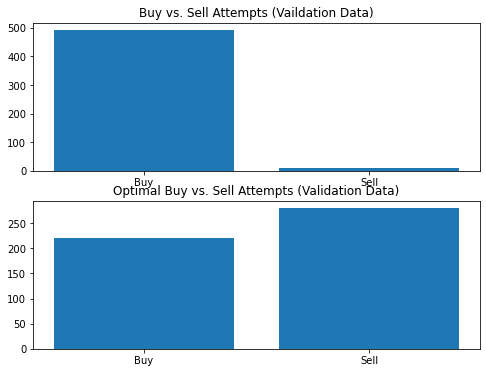

In [27]:
# CITATION: https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm
tradingActionsTest['trueTomorrow'] = tradingActionsTest['Open'].shift(-1)
tradingActionsTest['trueAction'] = np.where(tradingActionsTest['trueTomorrow'] - tradingActionsTest['Open'] > 0, 'buy', 'sell')


fig, axes = plt.subplots(2, figsize=(8, 6))
actions = ['Buy', 'Sell']
students = [np.sum(tradingActionsTest['action'] == 'buy'),np.sum(tradingActionsTest['action'] == 'sell')]
axes[0].bar(actions,students)
axes[0].set_title('Buy vs. Sell Attempts (Vaildation Data)')

students = [np.sum(tradingActionsTest['trueAction'] == 'buy'),np.sum(tradingActionsTest['trueAction'] == 'sell')]
axes[1].bar(actions,students)
axes[1].set_title('Optimal Buy vs. Sell Attempts (Validation Data)')

It is clear that we are almost always buying.  This is in stark contrast with the truth where we should actually be selling more than we are buying.  The reason for this is that we are constantly overestimating the truth, this causes our predicted opening price to almost always be larger than our current opening price.  Thus we almost always predict the stock will increase so we buy stock.  Lets check the training data to see how we are doing there as well.

Text(0.5, 1.0, 'Optimal Buy vs. Sell Attempts (Training Data)')

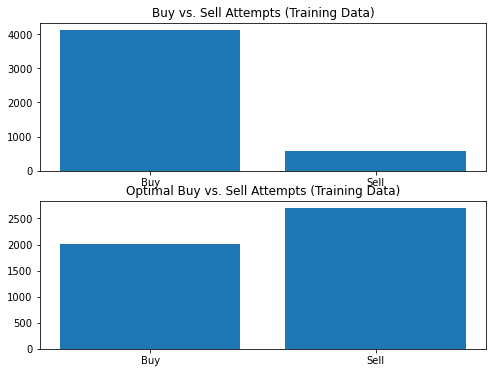

In [28]:


# CITATION: https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm
tradingActionsTrain['trueTomorrow'] = tradingActionsTrain['Open'].shift(-1)
tradingActionsTrain['trueAction'] = np.where(tradingActionsTrain['trueTomorrow'] - tradingActionsTrain['Open'] > 0, 'buy', 'sell')

fig, axes = plt.subplots(2, figsize=(8, 6))
actions = ['Buy', 'Sell']
students = [np.sum(tradingActionsTrain['action'] == 'buy'),np.sum(tradingActionsTrain['action'] == 'sell')]
axes[0].bar(actions,students)
axes[0].set_title('Buy vs. Sell Attempts (Training Data)')

students = [np.sum(tradingActionsTrain['trueAction'] == 'buy'),np.sum(tradingActionsTrain['trueAction'] == 'sell')]
axes[1].bar(actions,students)
axes[1].set_title('Optimal Buy vs. Sell Attempts (Training Data)')

The results appear to be the same.

We can clearly see that we are attempting to buy stock far more than we are trying to sell.  Of course this begs the question why is this occuring.  The answer is actually quite simple.  Due to the complete overestimation are model makes, we the change in opening stock price (PredictedOpeningPrice - CurrentOpeningPrice) is rarely negative since we always predict the opening stock price to be larger than it actually is.  Clearly, this is a problem.  We now have 3 avenues to choose from to remedy this.  One, we can choose a different model.  Two, simply subtract the average residual from our predicted values to reduce the overestimation.  Third, we can make a crucial observation of our model that will be explained shortly.  First, we immediately disregard option one due to its difficulty and low probability of success. As for options two and three, we will investigate.

### Model Corrections

#### Option 1: Subtract Average Residual

Lets first investigate option two.  To do so lets first divide the training data into subsets.  While this certainly is not ideal to further restrict our validation data, we would like to keep some subset of data as a true validation set.  We will first investigate the residuals to see if they appear to be constant.

In [29]:
numDataPoints = int(len(xTest)/2)
tradingActionsTest1 = tradingActionsTest.iloc[0:numDataPoints,:]
tradingActionsTest2 = tradingActionsTest.iloc[numDataPoints:,:]

Text(0.5, 1.0, 'Residuals of Model Predictions')

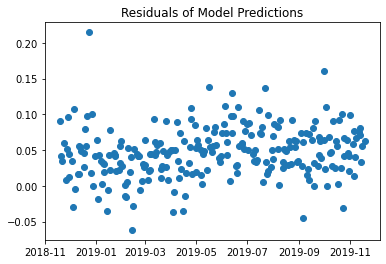

In [30]:
plt.plot(tradingActionsTest1['residuals'],'o')
plt.title('Residuals of Model Predictions')

Looking at the residuals, they do appear to be relatively constant.  It may be feasible to simply drop the model predictions by subtracting the average of the residuals from the predicted values.  Lets try this.

In [31]:
avgResidual = np.average(tradingActionsTest1['residuals'])
tradingActionsTest1['residualPrediction'] = tradingActionsTest1['predicted'].values - avgResidual

<ipython-input-31-e56ad59d475a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradingActionsTest1['residualPrediction'] = tradingActionsTest1['predicted'].values - avgResidual


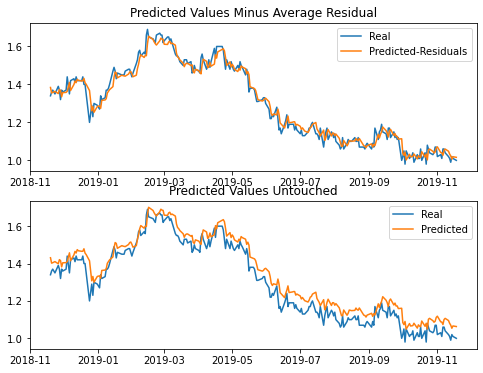

In [32]:
fig, axes = plt.subplots(2, figsize=(8, 6))


# Top Left Subplot
axes[0].plot(tradingActionsTest1['Open'])
axes[0].plot(tradingActionsTest1['residualPrediction'])
axes[0].set_title("Predicted Values Minus Average Residual")
axes[0].legend(['Real', 'Predicted-Residuals'])


# Top Right Subplot
axes[1].plot(tradingActionsTest1['Open'])
axes[1].plot(tradingActionsTest1['predicted'])
axes[1].set_title("Predicted Values Untouched")
axes[1].legend(['Real', 'Predicted'])



In [33]:
tradingActionsTest1['residualAction'] = np.where(tradingActionsTest1['residualPrediction'] - tradingActionsTest1['Open'] > 0, 
                                                 'buy', 
                                                 'sell')


<ipython-input-33-46a8b9a1f9db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradingActionsTest1['residualAction'] = np.where(tradingActionsTest1['residualPrediction'] - tradingActionsTest1['Open'] > 0,


Text(0.5, 1.0, 'Optimal Buy vs. Sell Attempts (Training Data)')

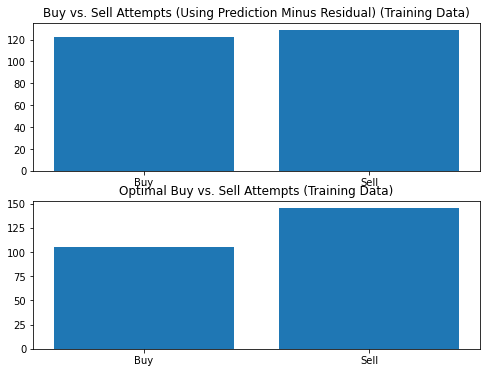

In [34]:
fig, axes = plt.subplots(2, figsize=(8, 6))
actions = ['Buy', 'Sell']
students = [np.sum(tradingActionsTest1['residualAction'] == 'buy'),np.sum(tradingActionsTest1['residualAction'] == 'sell')]
axes[0].bar(actions,students)
axes[0].set_title('Buy vs. Sell Attempts (Using Prediction Minus Residual) (Training Data)')

students = [np.sum(tradingActionsTest1['trueAction'] == 'buy'),np.sum(tradingActionsTest1['trueAction'] == 'sell')]
axes[1].bar(actions,students)
axes[1].set_title('Optimal Buy vs. Sell Attempts (Training Data)')

We have clearly significantly improved the number of times we are selling stocks.  Lets check our test data

In [35]:
tradingActionsTest2['residualPrediction'] = tradingActionsTest2['predicted'].values - avgResidual

<ipython-input-35-0427b667ae11>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradingActionsTest2['residualPrediction'] = tradingActionsTest2['predicted'].values - avgResidual


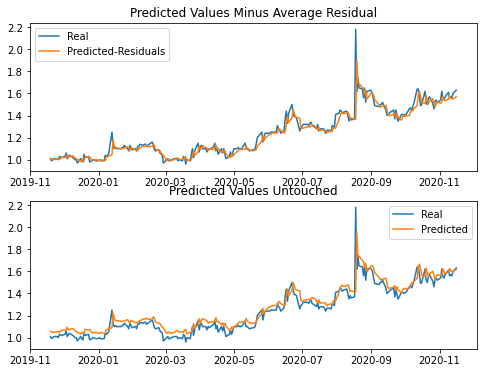

In [36]:
fig, axes = plt.subplots(2, figsize=(8, 6))

tradingActionsTest2


# Top Left Subplot
axes[0].plot(tradingActionsTest2['Open'])
axes[0].plot(tradingActionsTest2['residualPrediction'])
axes[0].set_title("Predicted Values Minus Average Residual")
axes[0].legend(['Real', 'Predicted-Residuals'])


# Top Right Subplot
axes[1].plot(tradingActionsTest2['Open'])
axes[1].plot(tradingActionsTest2['predicted'])
axes[1].set_title("Predicted Values Untouched")
axes[1].legend(['Real', 'Predicted'])

<ipython-input-37-dca8c56f88f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradingActionsTest2['residualAction'] = np.where(tradingActionsTest2['residualPrediction'] - tradingActionsTest2['Open'] > 0,


Text(0.5, 1.0, 'Optimal Buy vs. Sell Attempts (Training Data)')

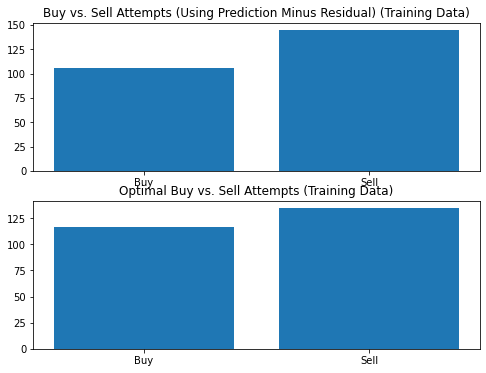

In [37]:
tradingActionsTest2['residualAction'] = np.where(tradingActionsTest2['residualPrediction'] - tradingActionsTest2['Open'] > 0, 
                                                 'buy', 
                                                 'sell')

fig, axes = plt.subplots(2, figsize=(8, 6))
actions = ['Buy', 'Sell']
students = [np.sum(tradingActionsTest2['residualAction'] == 'buy'),np.sum(tradingActionsTest2['residualAction'] == 'sell')]
axes[0].bar(actions,students)
axes[0].set_title('Buy vs. Sell Attempts (Using Prediction Minus Residual) (Training Data)')

students = [np.sum(tradingActionsTest2['trueAction'] == 'buy'),np.sum(tradingActionsTest2['trueAction'] == 'sell')]
axes[1].bar(actions,students)
axes[1].set_title('Optimal Buy vs. Sell Attempts (Training Data)')

Our results are the same. However what must be checked now is how often are we selling or buying when we should be.  (with respect to the truth)

In [38]:
np.sum(tradingActionsTest1['trueAction'] == tradingActionsTest1['residualAction'])/len(tradingActionsTest1)

0.6135458167330677

With respect to our training data, we are buying/selling correctly about 61% of the time.

In [39]:
np.sum(tradingActionsTest2['trueAction'] == tradingActionsTest2['residualAction'])/len(tradingActionsTest2)

0.5856573705179283

With respect to our Testing data, we are buying/selling correctly about 59% of the time.  Considering these are stock data, this is actually not bad.  Of course the question must be asked, could this be improved.  One possibility is to instead of taking simply the average of the residual, is to use a moving average.  Lets see how this effects our predictions.

In [40]:
tradingActionsTest1 = tradingActionsTest1[['Open','residuals', 'predicted','tomorrow','trueTomorrow','trueAction']]
tradingActionsTest2 = tradingActionsTest2[['Open','residuals', 'predicted','tomorrow','trueTomorrow','trueAction']]
# tradingActionsTrain = tradingActionsTrain.drop(['action'],axis=1)

In [41]:
for lookBack in range(20,300,20):
    tradingActionsTest1_full = pd.concat([tradingActionsTrain.iloc[-lookBack:,],tradingActionsTest1])
    movingResidualAvg = []
    for i in range(lookBack, len(tradingActionsTest1_full)):
        residualAverage = np.average(tradingActionsTest1_full.iloc[i-lookBack:i,:]['residuals'])
        movingResidualAvg.append(residualAverage )
        
    tradingActionsTest1['movingResidual'] = movingResidualAvg
    tradingActionsTest1['predictedResidualTomorrow'] = tradingActionsTest1['tomorrow'] - tradingActionsTest1['movingResidual']
    tradingActionsTest1['residualAction'] = np.where(tradingActionsTest1['predictedResidualTomorrow'] - tradingActionsTest1['Open']>0,
                                                    'buy',
                                                    'sell')
    print("Look Back:", lookBack)
    print(np.sum(tradingActionsTest1['residualAction'] ==   tradingActionsTest1['trueAction'])/len(tradingActionsTest1))
    print("********************************")

Look Back: 20
0.6135458167330677
********************************
Look Back: 40
0.6055776892430279
********************************
Look Back: 60
0.5697211155378487
********************************
Look Back: 80
0.5976095617529881
********************************
Look Back: 100
0.5976095617529881
********************************
Look Back: 120
0.6215139442231076
********************************
Look Back: 140
0.6095617529880478
********************************
Look Back: 160
0.6294820717131474
********************************
Look Back: 180
0.6374501992031872
********************************
Look Back: 200
0.6294820717131474
********************************
Look Back: 220
0.6175298804780877
********************************
Look Back: 240
0.6095617529880478
********************************
Look Back: 260
0.601593625498008
********************************
Look Back: 280
0.6175298804780877
********************************


In [42]:
tradingActionsTest1 = tradingActionsTest1[['Open','residuals', 'predicted','tomorrow','trueTomorrow','trueAction']]

In [43]:
lookBack = 180
tradingActionsTest2_full = pd.concat([tradingActionsTest1.iloc[-lookBack:,],tradingActionsTest2])

movingResidualAvg = []
for i in range(lookBack, len(tradingActionsTest2_full)):
    residualAverage = np.average(tradingActionsTest2_full.iloc[i-lookBack:i,:]['residuals'])
    movingResidualAvg.append(residualAverage )
    
tradingActionsTest2['movingResidual'] = movingResidualAvg
tradingActionsTest2['predictedResidualTomorrow'] = tradingActionsTest2['tomorrow'] - tradingActionsTest2['movingResidual']
tradingActionsTest2['residualAction'] = np.where(tradingActionsTest2['predictedResidualTomorrow'] - tradingActionsTest2['Open']>0,
                                                'buy',
                                                'sell')
print(np.sum(tradingActionsTest2['residualAction'] ==   tradingActionsTest2['trueAction'])/len(tradingActionsTest2))

0.6215139442231076


In [44]:
boostModel(tradingActionsTrain, tradingActionsTest)

,Open,residuals,predicted,tomorrow,action,trueTomorrow,trueAction,movingResidual,predictedTomorrow
Date,,,,,,,,,
2018-11-19,1.34,0.091030,1.431030,1.402103,buy,1.36,buy,0.038531,1.363572
2018-11-20,1.36,0.042103,1.402103,1.404446,buy,1.37,buy,0.039122,1.365324
2018-11-21,1.37,0.034446,1.404446,1.410371,buy,1.35,sell,0.039239,1.371132
2018-11-23,1.35,0.060371,1.410371,1.398772,buy,1.39,buy,0.039750,1.359023
2018-11-26,1.39,0.008772,1.398772,1.420981,sell,1.37,sell,0.040562,1.380419
...,...,...,...,...,...,...,...,...,...
2020-11-10,1.56,0.066635,1.626635,1.603079,buy,1.57,buy,0.034978,1.568101
2020-11-11,1.57,0.033079,1.603079,1.601632,sell,1.56,sell,0.035017,1.566615
2020-11-12,1.56,0.041632,1.601632,1.596276,buy,1.60,buy,0.034890,1.561386


In [45]:
print(score(tradingActionsTest))

0.6294820717131474


In [46]:
tradingActionsFinal = tradingActionsTest[['Open', 'predictedTomorrow', 'action']]
tradingActionsFinal = tradingActionsFinal.rename(columns={'action':'predictedAction'})
tradingActionsFinal['predicted'] = tradingActionsFinal['predictedTomorrow'].shift(1)
tradingActionsFinal['stock'] = 'forward'
tradingActionsFinal

,Open,predictedTomorrow,predictedAction,predicted,stock
Date,,,,,
2018-11-19,1.34,1.363572,buy,NaN,forward
2018-11-20,1.36,1.365324,buy,1.363572,forward
2018-11-21,1.37,1.371132,buy,1.365324,forward
2018-11-23,1.35,1.359023,buy,1.371132,forward
2018-11-26,1.39,1.380419,sell,1.359023,forward
...,...,...,...,...,...
2020-11-10,1.56,1.568101,buy,1.591194,forward
2020-11-11,1.57,1.566615,sell,1.568101,forward
2020-11-12,1.56,1.561386,buy,1.566615,forward


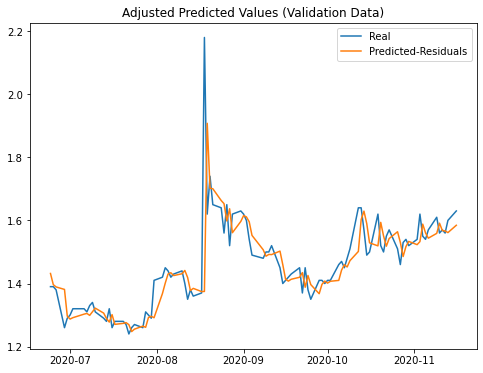

In [38]:
tradingActionsFinal
fig, axes = plt.subplots(1, figsize=(8, 6))

# Top Left Subplot
axes.plot(tradingActionsFinal['Open'][400:])
axes.plot(tradingActionsFinal['predicted'][400:])
axes.set_title("Adjusted Predicted Values (Validation Data)")
axes.legend(['Real', 'Predicted-Residuals'])

In [27]:
tradingActionsFinal.to_csv('Data/Final Predictions/forwardComplete.csv')